# 1. Data Reading and Understanding

In [ ]:
# om ganeshay namah

# importing libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# using Google drive to get data into the colab
base_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

# List the class names
class_names = sorted(os.listdir(train_dir))
print("Classes:", class_names)


Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 2. Dataset Creation

In [ ]:
IMG_SIZE = (180, 180)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


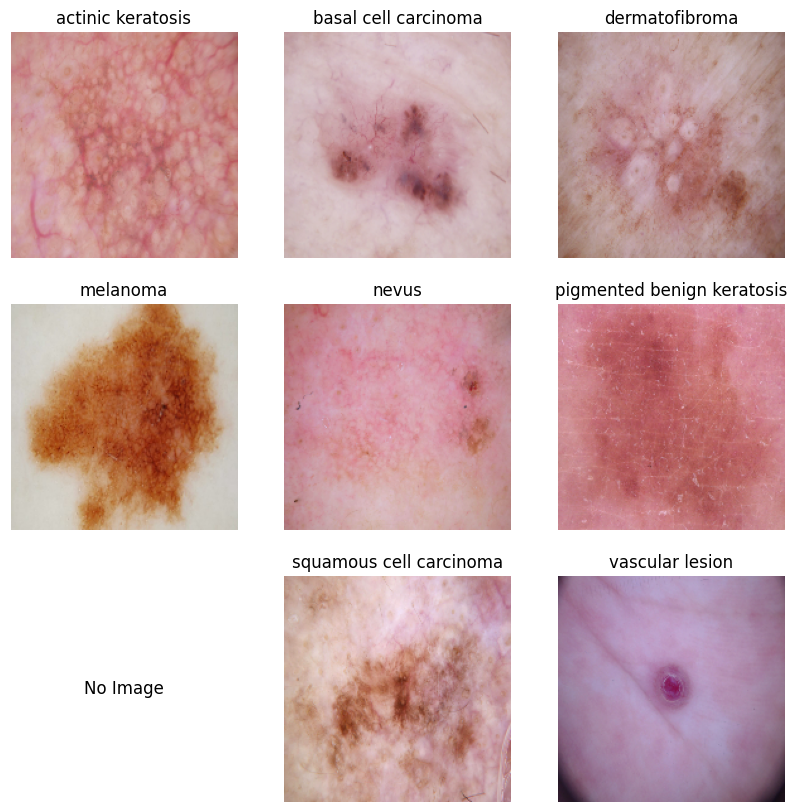

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Take one batch of images and labels
for images, labels in train_ds.take(1):
    for i in range(len(class_names)):
        ax = plt.subplot(3, 3, i + 1)

        # Find the first image for each class
        idx = (labels == i).numpy().nonzero()[0]

        if len(idx) > 0:  # Check if there is at least one image of this class in the batch
            plt.imshow(images[idx[0]].numpy().astype("uint8"))
            plt.title(class_names[i])
        else:
            plt.text(0.5, 0.5, "No Image", ha="center", va="center", fontsize=12)

        plt.axis("off")

plt.show()


# Phase A

Training the model without any agumentation.
Directly on Raw data.

In [ ]:
|from tensorflow.keras import layers, models

# Defining the model architecture
def create_model():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(180, 180, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])
    return model

model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for ~20 epochs
history = model.fit(train_ds, validation_data=val_ds, epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 389s 7s/step - accuracy: 0.2509 - loss: 2.0168 - val_accuracy: 0.4519 - val_loss: 1.6675
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 327ms/step - accuracy: 0.4147 - loss: 1.6376 - val_accuracy: 0.4966 - val_loss: 1.5022
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.4904 - loss: 1.4721 - val_accuracy: 0.4944 - val_loss: 1.4457
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.5250 - loss: 1.3818 - val_accuracy: 0.4922 - val_loss: 1.4690
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.5361 - loss: 1.3193 - val_accuracy: 0.5257 - val_loss: 1.3853
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 326ms/step - accuracy: 0.5665 - loss: 1.2497 - val_accuracy: 0.4877 - val_loss: 1.4939
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.5406 - loss: 1.2539 - val_accuracy: 0.4855 - val_loss: 1.5498
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 315ms/step - accuracy: 0.5680 - loss: 1.2239 - val_accura

## Insights
Here we have experience the issue of Overfitting.

*key Observation*
1. Accuracy improves from 25.09% → 86.3% (Epoch 1 to 20)
2. Loss decreases from 2.0168 → 0.3734.

But we have observed validation Accuracy and Loss to behave something other than training as

1. Accuracy peaks around 52%, then declines.
2. Loss increases from 1.6675 → 2.2936.

**Conclusion**: Model perform well on training data but fell to generalize new data, which means it's OVERFITTING.

Now we will agument the data. Since we’re dealing with skin lesion images, we should use augmentation techniques that preserve medical details but improve generalization.
We’ll apply the following augmentations:

- Random Flip (horizontal & vertical)

- Random Rotation (up to 20 degrees)
-  Random Zoom (zoom in slightly)
- Brightness adjustments (small variations)
- Random Translation & Shear

# Phase 2

Applying augmentation on data and seeing the output of train.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define augmentation layers
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),   # Flip in both directions
    layers.RandomRotation(0.2),                     # Rotate images by 20%
    layers.RandomZoom(0.1),                         # Zoom in by 10%
    layers.RandomBrightness(0.2),                   # Adjust brightness
    layers.RandomTranslation(0.1, 0.1),             # Move image slightly
    layers.RandomContrast(0.2)                      # Adjust contrast
])

# Apply augmentation to the training dataset
BATCH_SIZE = 32
IMG_SIZE = (180, 180)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Apply augmentation only to training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [ ]:
# Define CNN Model (Same as before)
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalize pixels
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),  # Reduce overfitting
    layers.Dense(9, activation="softmax")  # Output layer with 9 classes
])

# Compile model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model for 20 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 618ms/step - accuracy: 0.2282 - loss: 2.1447 - val_accuracy: 0.2174 - val_loss: 2.4113
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 36s 570ms/step - accuracy: 0.3070 - loss: 1.8892 - val_accuracy: 0.2174 - val_loss: 2.3642
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 39s 543ms/step - accuracy: 0.3709 - loss: 1.7512 - val_accuracy: 0.3043 - val_loss: 2.2298
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 551ms/step - accuracy: 0.3466 - loss: 1.8037 - val_accuracy: 0.2609 - val_loss: 2.3196
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 530ms/step - accuracy: 0.3878 - loss: 1.7100 - val_accuracy: 0.3043 - val_loss: 2.7949
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 533ms/step - accuracy: 0.4323 - loss: 1.5984 - val_accuracy: 0.2174 - val_loss: 2.8772
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 536ms/step - accuracy: 0.4694 - loss: 1.5556 - val_accuracy: 0.3043 - val_loss: 2.5992
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 532ms/step - accuracy: 0.4644 - loss: 1.5600 - val_accuracy: 0.304

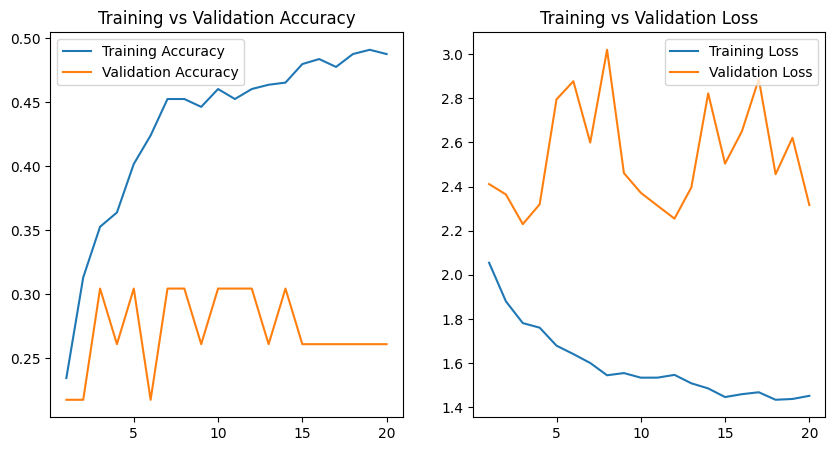

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()


## Insights:

Observation
1. training accuarcy improved from 22% to 50 .
2. Validation acc is 25-30% show poor generalization
3. validation loss is high and unstable indicate severe class imbalance.

Conclusion: As we can have some improvement in training accarcy not get increased immedieately, so agumentaiton work but it limits if our class is imbalanced.

# Class imbalance in data

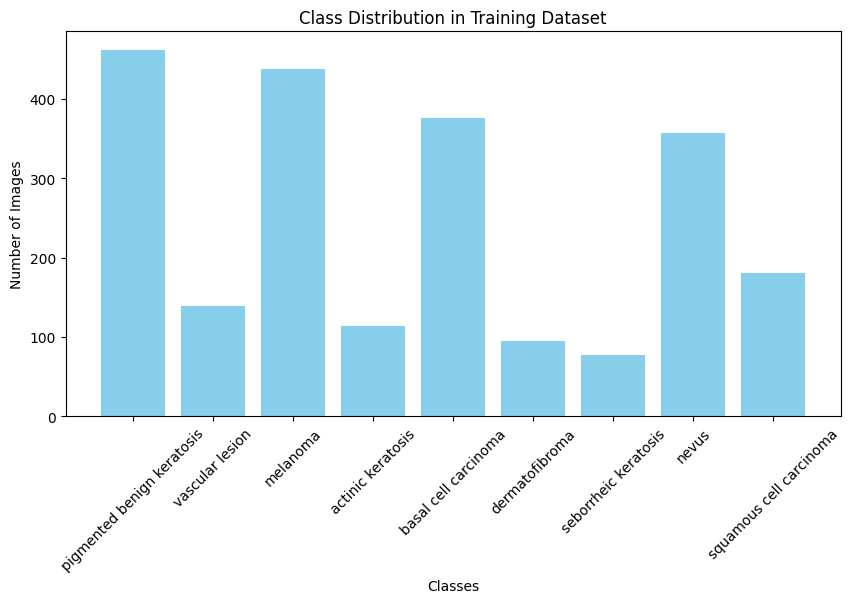

Class Distribution: {'pigmented benign keratosis': 462, 'vascular lesion': 139, 'melanoma': 438, 'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'seborrheic keratosis': 77, 'nevus': 357, 'squamous cell carcinoma': 181}


In [ ]:
import os
import matplotlib.pyplot as plt


class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)}

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()


print("Class Distribution:", class_counts)


**Insights**: Here we can here there is severe class imbalance in dataset.

# Phase 3

Using `Augmentor` Library, we will rectify the class imbalance.

In [ ]:
# importing the library
!pip install Augmentor


In [ ]:
import Augmentor
import os

# Define the dataset path
train_dir = '/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

# Find the maximum number of images in any class
max_count = max(class_counts.values())

# Apply augmentation to underrepresented classes
for class_name, count in class_counts.items():
    if count < max_count:  # Only augment minority classes
        class_path = os.path.join(train_dir, class_name)

        # Create an Augmentor pipeline
        p = Augmentor.Pipeline(class_path)

        # Add augmentation operations
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.flip_left_right(probability=0.5)
        p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
        p.skew(probability=0.5)

        # Generate enough images to match the majority class
        samples_to_generate = max_count - count
        p.sample(samples_to_generate)

print("Data augmentation complete!")


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ECB229EAD0>: 100%|██████████| 323/323 [00:16<00:00, 20.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x78ECB2408590>: 100%|██████████| 24/24 [00:06<00:00,  3.44 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ECB25F1F90>: 100%|██████████| 348/348 [00:18<00:00, 18.81 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ECB2408190>: 100%|██████████| 86/86 [00:04<00:00, 17.49 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ECB241C310>: 100%|██████████| 367/367 [00:19<00:00, 18.85 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78ECB22D3450>: 100%|██████████| 385/385 [00:48<00:00,  7.90 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ECB2409AD0>: 100%|██████████| 105/105 [00:24<00:00,  4.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78ECB2EC7B50>: 100%|██████████| 281/281 [00:14<00:00, 19.19 Samples/s]

Data augmentation complete!


So this above code will generate output folder in each folder of class. So to stay safe I have just copied the image and images from output folder into separate folder named Train2.

In [ ]:
import os
import shutil

# Paths
original_train_dir = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
new_train_dir = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train2"

# Ensure the new directory exists
os.makedirs(new_train_dir, exist_ok=True)

# Iterate over each class folder in the original train directory
for class_name in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_name)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        output_path = os.path.join(class_path, "output")  # Path to output folder

        # Check if output folder exists inside the class folder
        if os.path.exists(output_path):
            new_class_path = os.path.join(new_train_dir, class_name)  # New path in train2

            # Create the new class folder in train2
            os.makedirs(new_class_path, exist_ok=True)

            # Copy all images from output/ to the new train2/class_name/ folder
            for img_name in os.listdir(output_path):
                img_path = os.path.join(output_path, img_name)
                if os.path.isfile(img_path):
                    shutil.copy(img_path, os.path.join(new_class_path, img_name))

print("Augmented images copied to Train2 successfully!")


Augmented images copied to Train2 successfully!


In [ ]:
import os
import shutil

# Paths
original_train_dir = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
new_train_dir = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train2"

# Iterate over each class folder in the original train directory
for class_name in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_name)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        new_class_path = os.path.join(new_train_dir, class_name)  # Path in Train2

        # Ensure the corresponding class folder exists in Train2
        os.makedirs(new_class_path, exist_ok=True)

        # Copy original images (excluding images inside "output" folder)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Skip "output" folder
            if img_name == "output":
                continue

            # Copy only images (not directories)
            if os.path.isfile(img_path):
                shutil.copy(img_path, os.path.join(new_class_path, img_name))

print("Original images merged into Train2 successfully!")


Original images merged into Train2 successfully!


So now all the images are been copied, we will just final how the bar looks like.

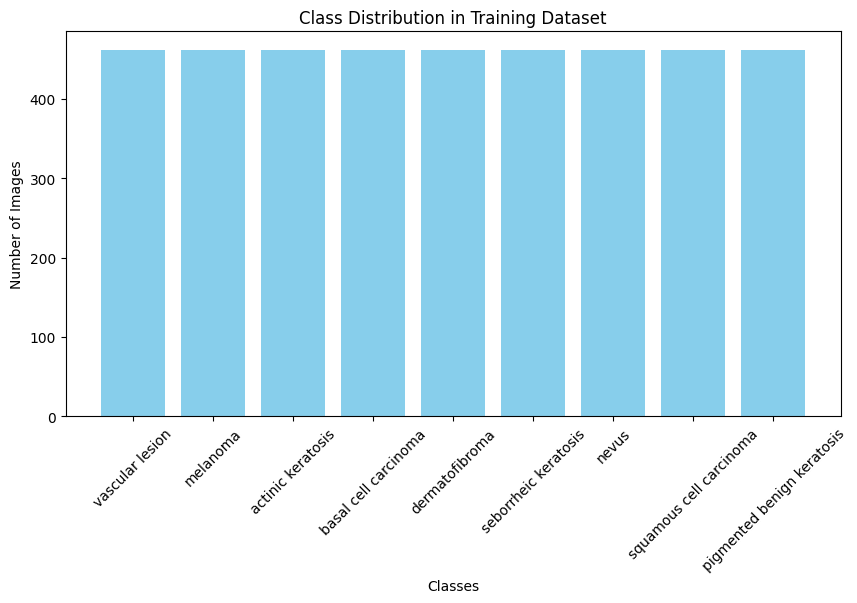

Class Distribution: {'vascular lesion': 462, 'melanoma': 462, 'actinic keratosis': 462, 'basal cell carcinoma': 462, 'dermatofibroma': 462, 'seborrheic keratosis': 462, 'nevus': 462, 'squamous cell carcinoma': 462, 'pigmented benign keratosis': 462}


In [ ]:

import os
import matplotlib.pyplot as plt

# Define dataset paths
train_dir = "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train2"

# Count number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)}

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.xticks(rotation=45)
plt.show()

# Print class counts
print("Class Distribution:", class_counts)


As now class imbalance is rectified I will continue with normal procedure.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Parameters
img_size = (180, 180)
batch_size = 32

# Data Augmentation & Splitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% of images used for validation
)

# Load Training Data (80% of Train2)
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train2",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"  # Use 80% for training
)

# Load Validation Data (20% of Train2)
val_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train2",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"  # Use 20% for validation
)

# Get number of classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")


Found 3330 images belonging to 9 classes.
Found 828 images belonging to 9 classes.
Number of classes: 9


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization # Import BatchNormalization


# Build Model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(180,180,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])


from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)  # Reduce learning rate
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])



# Summary
model.summary()

# Train Model
epochs = 25

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    verbose=1
)

# Save Model
model.save("/content/drive/MyDrive/skin_cancer_model_phase3.h5")
print("Model saved successfully!")


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 71s 646ms/step - accuracy: 0.1252 - loss: 2.2111 - val_accuracy: 0.1063 - val_loss: 2.1824
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 617ms/step - accuracy: 0.2000 - loss: 2.0943 - val_accuracy: 0.2017 - val_loss: 1.9856
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 623ms/step - accuracy: 0.2656 - loss: 1.9188 - val_accuracy: 0.2983 - val_loss: 1.8476
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 621ms/step - accuracy: 0.3101 - loss: 1.7710 - val_accuracy: 0.3249 - val_loss: 1.7780
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 67s 641ms/step - accuracy: 0.3363 - loss: 1.7226 - val_accuracy: 0.3261 - val_loss: 1.7192
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 625ms/step - accuracy: 0.3592 - loss: 1.6743 - val_accuracy: 0.3913 - val_loss: 1.7888
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 625ms/step - accuracy: 0.3674 - loss: 1.6584 - val_accuracy: 0.3575 - val_loss: 1.7252
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 623ms/step - accuracy: 0.3752 - loss: 1

Model saved successfully!


Here we can accaracy is increasing with increase in validation, So there is still more training needed. If we train the model for about 100-150 epoch then it will surely perform better.

Thank you !